In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import gc

from shared.utils import *
from shared.colab_path import *

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

strategy = tf.distribute.MirroredStrategy()

# Data Preprocessing
## Audio Data

In [ ]:
label = []
filepath = []

for classes in os.listdir(AUDIO_PATH):
    for file in os.listdir(os.path.join(AUDIO_PATH, classes)):
        file_path = os.path.join(AUDIO_PATH, classes, file)

        filepath.append(file_path)
        label.append(classes)

audio = pd.DataFrame({
    'filepath': filepath,
    'label': label,
})

del filepath, label

audio.head()

In [ ]:
le = LabelEncoder()
le.fit(audio['label'])
audio['label_encoded'] = le.transform(audio['label'])
num_classes = len(le.classes_)

In [ ]:
with tf.device('/GPU:0'):
    audio['data'] = audio.filepath.apply(preprocess_audio)

In [ ]:
x_audio = np.stack(audio['data'].values)
y_audio = audio['label_encoded'].values
print(x_audio.shape)
del audio

In [ ]:
x_audio_train, x_temp, y_audio_train, y_temp = train_test_split(
    x_audio, y_audio, test_size=0.3, random_state=42, shuffle=True
)

x_audio_val, x_audio_test, y_audio_val, y_audio_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42,
)

del x_audio, y_audio
print(x_audio_train.shape)

In [ ]:
print(x_audio_train.shape[0] == len(y_audio_train))

## Image Data

In [ ]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

In [ ]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

In [ ]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
img_test_df['label_encoded'] = le.transform(img_test_df['label'])

In [ ]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(lambda x : preprocess_image(x, (100, 100)))
    img_test_df['data'] = img_test_df['filepath'].apply(lambda x : preprocess_image(x, (100, 100)))

train_df.shape

In [ ]:
x_img = np.stack(train_df['data'].values)
y_img = train_df['label_encoded'].values

x_img_test = np.stack(img_test_df['data'].values)
y_img_test = img_test_df['label_encoded'].values

del train_df, img_test_df

x_img_train, x_img_val, y_img_train, y_img_val = train_test_split(x_img, y_img, test_size=0.2, random_state=42, stratify=y_img, shuffle=True)
del x_img, y_img

# Modeling

In [13]:
def create_base_model(inputs: tf.keras.layers.Input, instance_name: str) -> tf.keras.Model:
    base = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
    )
    outputs = base(inputs)
    base.trainable = False
    for layer in base.layers:
        layer.trainable = False
    return tf.keras.Model(inputs, outputs, name=f"inception_v3_{instance_name}")

In [15]:
input_image = tf.keras.Input(shape=(100, 100, 3), name='input_image')
input_audio = tf.keras.Input(shape=(128, 110, 3), name='input_audio')

image_base = create_base_model(input_image, 'image_base')
audio_base = create_base_model(input_audio, 'audio_base')

left = image_base(input_image)
right = audio_base(input_audio)

left = tf.keras.layers.Flatten()(left)
left = tf.keras.layers.Dense(512, activation='relu')(left)

right = tf.keras.layers.Flatten()(right)
right = tf.keras.layers.Dense(512, activation='relu')(right)

out1 = tf.keras.layers.Dense(7, activation='softmax', name='image_class')(left)
out2 = tf.keras.layers.Dense(8, activation='softmax', name='audio_class')(right)

model = tf.keras.models.Model(inputs=[input_image, input_audio], outputs=[out1, out2])


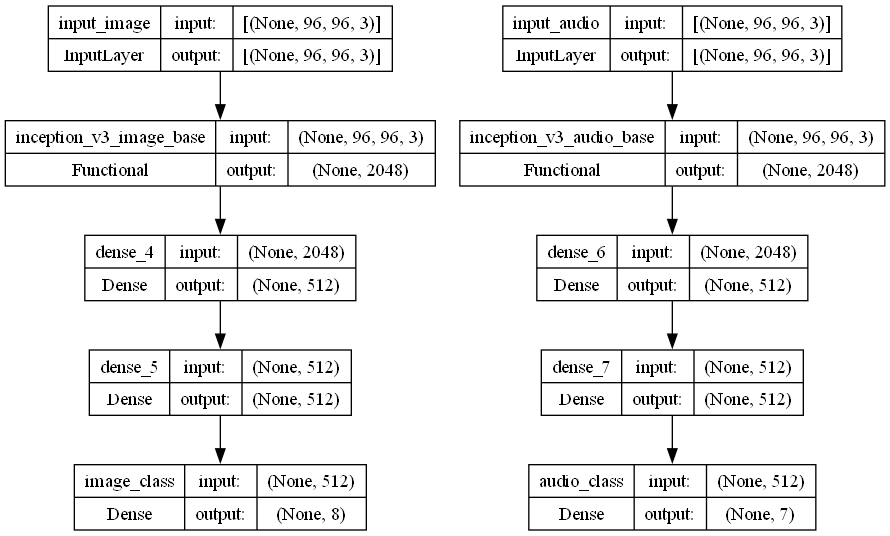

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss={
        'image_class': 'sparse_categorical_crossentropy',
        'audio_class': 'sparse_categorical_crossentropy'
    },
    metrics={
        'image_class': 'accuracy',
        'audio_class': 'accuracy'
    }
)

In [ ]:
min_samples = min(len(x_img_train), len(x_audio_train), len(y_img_train), len(y_audio_train))

# Filter inputs and labels
x_img_train = x_img_train[:min_samples]
x_audio_train = x_audio_train[:min_samples]
y_img_train = y_img_train[:min_samples]
y_audio_train = y_audio_train[:min_samples]

# Print shapes after filtering
print("Input Image Shape:", x_img_train.shape)
print("Input Audio Shape:", x_audio_train.shape)
print("Image Labels Shape:", y_img_train.shape)
print("Audio Labels Shape:", y_audio_train.shape)

print("Input Image Type:", x_img_train.dtype)
print("Input Audio Type:", x_audio_train.dtype)
print("Image Labels Type:", y_img_train.dtype)
print("Audio Labels Type:", y_audio_train.dtype)

In [ ]:
min_samples = min(len(x_img_val), len(x_audio_val), len(y_img_val), len(y_audio_val))

# Filter inputs and labels
x_img_val = x_img_val[:min_samples]
x_audio_val = x_audio_val[:min_samples]
y_img_val = y_img_val[:min_samples]
y_audio_val = y_audio_val[:min_samples]


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= os.path.join(MODEL_CHECKPOINT_PATH, 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    factor=0.2,
    min_lr=0.000001,
    patience=3,
    mode='min'
)

In [ ]:
history = model.fit(
    x=[x_img_train, x_audio_train],
    y=[y_img_train, y_audio_train],
    validation_data=(
        [x_img_val, x_audio_val],
        [y_img_val, y_audio_val]
    ),
    callbacks=[early, checkpoint],
    epochs=300,
    batch_size=64
)


In [ ]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [ ]:
plot_and_save('loss', history, 'Loss', 'loss_plot.png')
plot_and_save('image_class_loss', history, 'Image Classification Loss', 'image_class_loss_plot.png')
plot_and_save('audio_class_loss', history, 'Audio Classification Loss', 'audio_class_loss_plot.png')
plot_and_save('image_class_accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')
plot_and_save('audio_class_accuracy', history, 'Audio Classification Accuracy', 'audio_class_accuracy_plot.png')

In [ ]:
model.save('model.h5')